<a href="https://colab.research.google.com/github/hyungchanchoi/AlgorithmTrading_pykiwoom/blob/main/data%20anlaysis/kodex200_tiger200_analy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 
# start = (datetime.today() - timedelta()).strftime("%Y%m%d") 
# print(start, today)
pd.options.display.float_format = '{:.6f}'.format

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cd drive/My Drive/algorithmtrading/pair_trading/Datas

/content/drive/My Drive/algorithmtrading/pair_trading/Datas


In [3]:
def one_day(temp,test_day):
    
    begin = np.where( np.array(temp.index) > str(test_day))[0][0]
    end = np.where( str(test_day+1) > np.array(temp.index) )[0][-1]
    
    if len(temp.iloc[begin:end])==0:
        print(test_day,'는 공휴일 입니다.')
    else:
        return temp.iloc[begin-1:end]

# 1. 과거 1분단위 데이터 받아오기

In [ ]:
now = '20210120'

kodex200 = pd.read_pickle('KODEX 200(m)_'+now)
tiger200 = pd.read_pickle('TIGER 200(m)_'+now)

temp =  pd.merge(left = kodex200 , right = tiger200, how = "inner", on = "체결시간")
temp = temp.set_index('체결시간')
temp.columns = ['kodex200','volume','tiger200','volume']
temp = temp[['kodex200','tiger200']]

temp['kodex200']=pd.to_numeric(temp['kodex200'])
temp['tiger200']=pd.to_numeric(temp['tiger200'])

for i in range(len(temp)):
    if temp['kodex200'].iloc[i] < 0:
        temp['kodex200'].iloc[i] = -temp['kodex200'].iloc[i]
    if temp['tiger200'].iloc[i] < 0:
        temp['tiger200'].iloc[i] = -temp['tiger200'].iloc[i]


temp['tiger200'] = temp['tiger200']
temp['spread'] = temp['kodex200'] - temp['tiger200']
temp['kodex200_cumret'] = np.log(temp['kodex200']/temp['kodex200'][0])
temp['tiger200_cumret'] = np.log(temp['tiger200']/temp['tiger200'][0])
temp['ma10_spread'] = temp['spread'].rolling(window=10, center=False).mean()

temp

,kodex200,tiger200,spread,kodex200_cumret,tiger200_cumret,ma10_spread
체결시간,,,,,,
20200102100000,29221,29176,45,0.000000,0.000000,nan
20200102100100,29192,29152,40,-0.000993,-0.000823,nan
20200102100200,29206,29166,40,-0.000513,-0.000343,nan
20200102100300,29192,29152,40,-0.000993,-0.000823,nan
20200102100400,29152,29112,40,-0.002364,-0.002196,nan
...,...,...,...,...,...,...
20210119151600,42700,42660,40,0.379311,0.379915,25.000000
20210119151700,42700,42675,25,0.379311,0.380267,25.000000
20210119151800,42720,42690,30,0.379780,0.380618,27.000000


# 2. 일 단위로 데이터 저장하기 + 당일 수익률 계산

In [ ]:
df = {}
calender = []
for date in range(20201021,20210120):
    if 20201231 < date < 20210100:
        continue
    temps = pd.DataFrame()
    temps = one_day(temp,date)
    try:      
        temps['kodex200_dayret'] = np.log(temps['kodex200']/temps['kodex200'][0])
        temps['tiger200_dayret'] = np.log(temps['tiger200']/temps['tiger200'][0])
        temps['spread_cumret'] = temps['kodex200_cumret'] -temps['tiger200_cumret']
        temps['spread_dayret']= temps['kodex200_dayret'] - temps['tiger200_dayret'] 
        df[str(date)] = temps
        if len(temps) != 0:
            calender.append(str(date))
    except:
        pass
calender

# 3. 그래프 그리기

In [ ]:
for date in calender[-10:]:
    plt.rcParams["figure.figsize"] = (20, 10)
    df[date]['spread'].plot()
    # df[date]['ma10_spread'].plot()
    # temp_high = df[date]['ma10_spread'] +20
    # temp_low = df[date]['ma10_spread']-20
    # temp_high.plot(linestyle='--')
    # temp_low.plot(linestyle='--')
    # df[date]['kodex200'].plot()
    # df[date]['tiger200'].plot()
    # plt.axhline((0.0003), color='red', linestyle='--')
    # plt.axhline((-0.0003), color='red', linestyle='--')
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
# temp['kodex200_cumret'].plot()
# temp['kodex200_cumret'].plot()
# temp['tiger200_cumret'].plot()
temp['kodex200'].plot()
temp['tiger200'].plot()
# temp['ma30'].plot()

# 4. bidask 스프레드 확인

In [13]:
cd bidask

/content/drive/My Drive/algorithmtrading/pair_trading/bidask


In [66]:
now = '20210121'

kodex200_bidask = pd.read_pickle('KODEX 200_'+now)
tiger200_bidask = pd.read_pickle('TIGER 200_'+now)

bidask =  pd.merge(left = kodex200_bidask , right = tiger200_bidask, how = "inner", on = "time")
bidask.columns = ['kodex_bid','kodex_ask','tiger_bid','tiger_ask']
kodex_ask = bidask['kodex_ask']
kodex_bid = bidask['kodex_bid']
tiger_ask = bidask['tiger_ask']
tiger_bid = bidask['tiger_bid']
bidask

,kodex_bid,kodex_ask,tiger_bid,tiger_ask
time,,,,
153006,43530,43525,43520,43510
153005,43530,43525,43520,43510
153004,43535,43530,43515,43510
153000,43540,43535,43530,43525
152957,43535,43530,43530,43520
...,...,...,...,...
90048,43330,43310,43310,43280
90046,43315,43300,43305,43260
90044,43330,43315,43310,43270


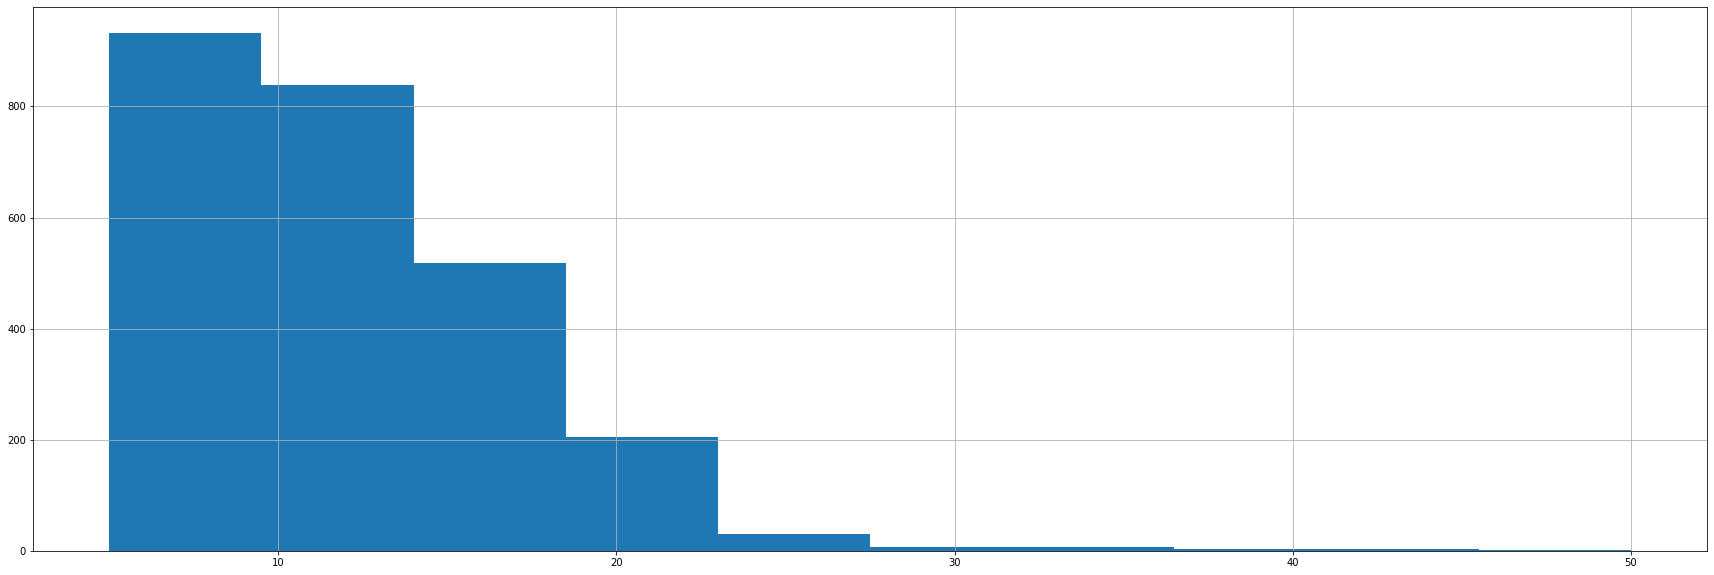

In [70]:
bidask_spread = tiger_bid-tiger_ask
bidask_spread.hist()

# tiger_ask_kodex_bid spread freaquency    (청산포지션)

-30    878
-25    669
-35    401
-20    309
-15    109
-10     62
-40     44
-5      24
 0      22
-45     10
-55      6
-50      4
 5       3
-70      1
-60      1
 15      1
-75      1
dtype: int64


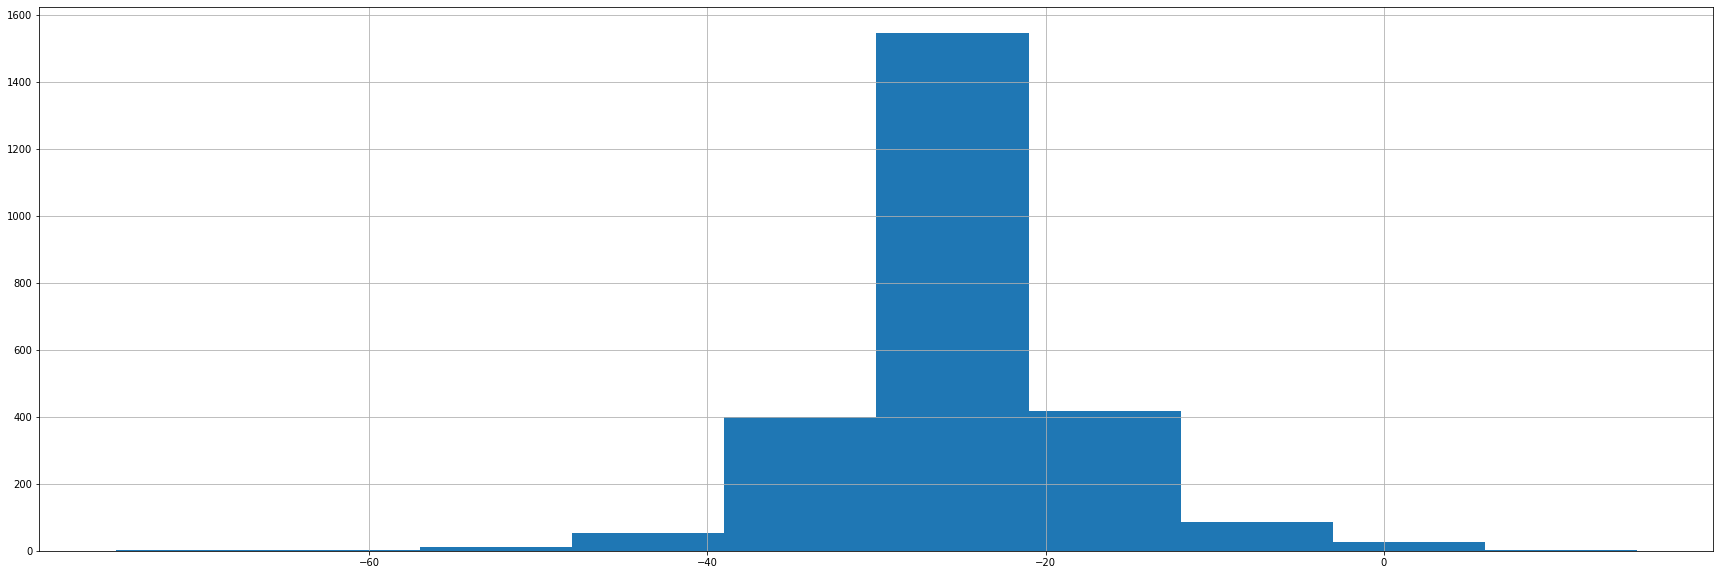

In [65]:
tiger_ask_kodex_bid = tiger_ask - kodex_bid
tiger_ask_kodex_bid.hist()
freq = tiger_ask_kodex_bid.value_counts() 
print(freq)

# kodex_ask_tiger_bid spread freaquency (포지션시작)

 10    716
 15    683
 5     444
 20    303
 0     156
-5     128
-10     60
 25     35
 30      7
-15      6
-20      3
-25      2
 55      1
-30      1
dtype: int64


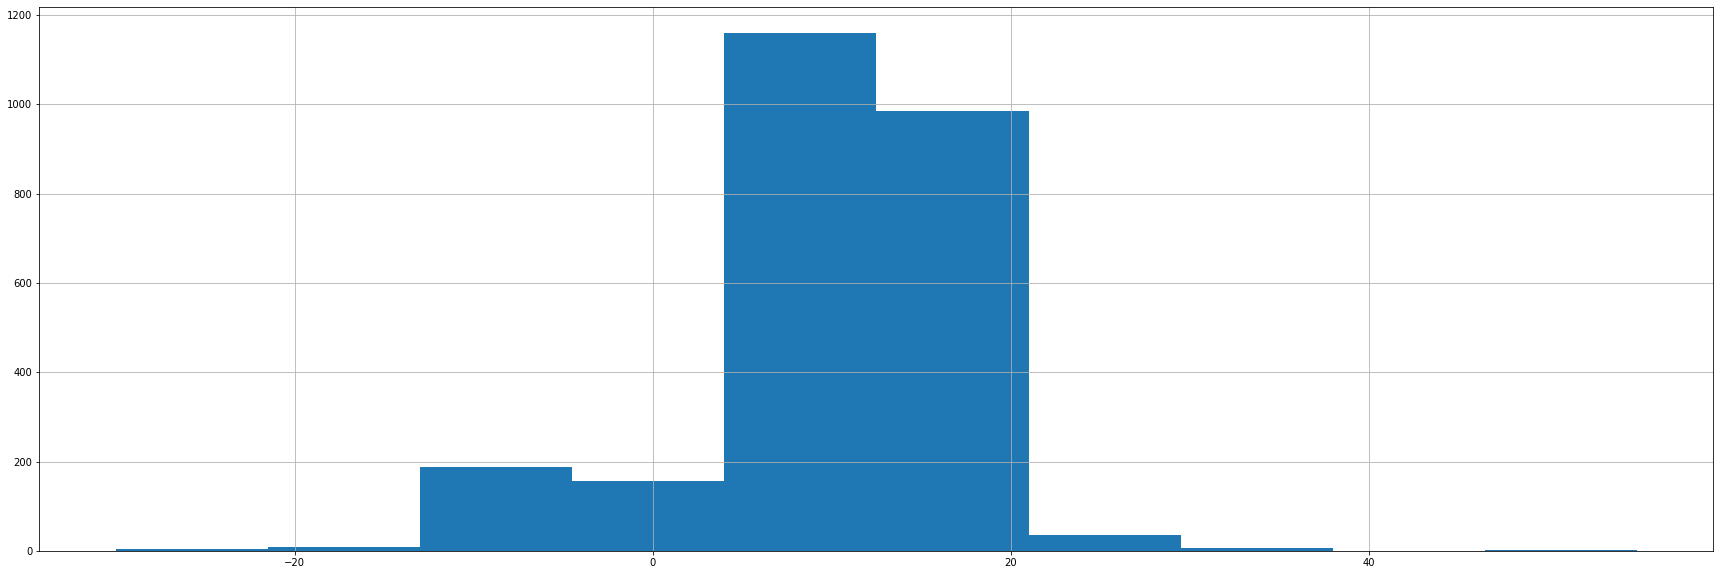

In [50]:
kodex_ask_tiger_bid = kodex_ask - tiger_bid
kodex_ask_tiger_bid.hist()
freq = kodex_ask_tiger_bid.value_counts() 
print(freq)

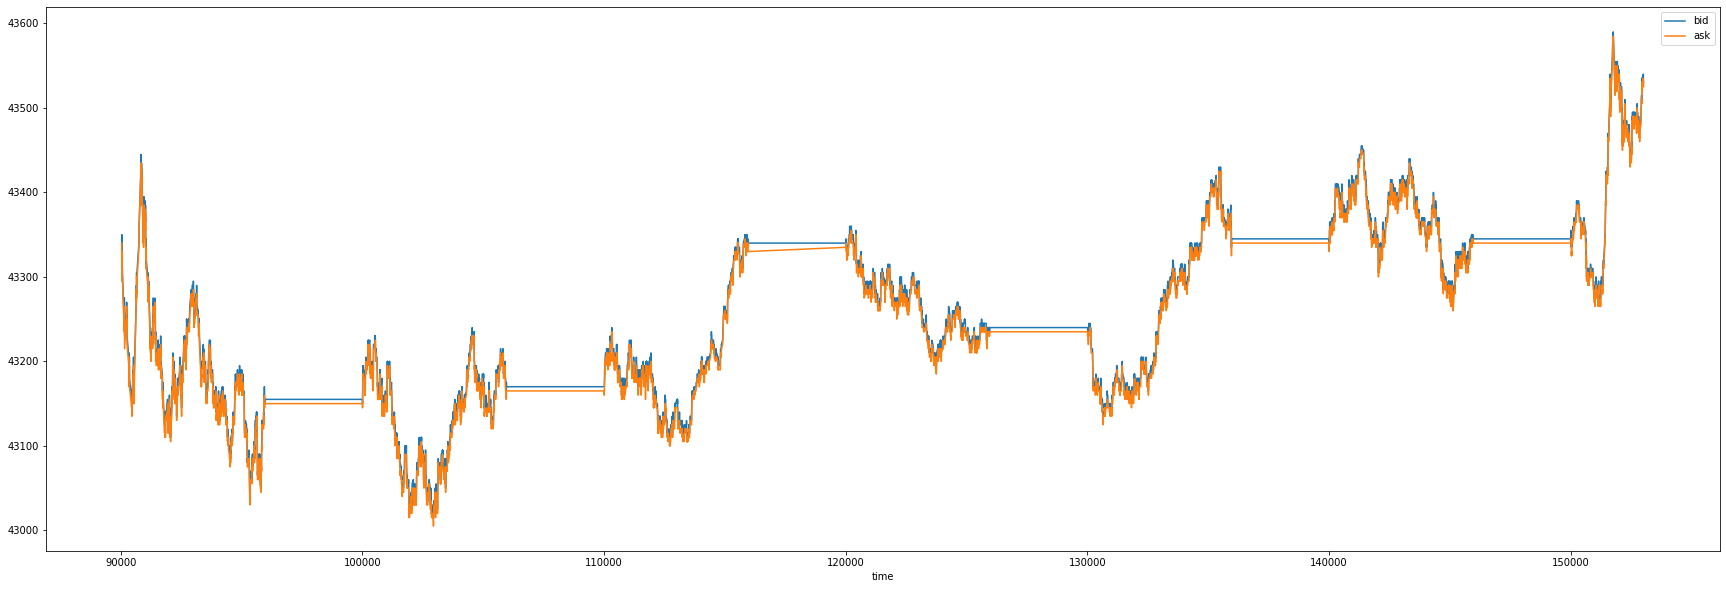

In [37]:
plt.rcParams["figure.figsize"] = (30, 10)
kodex200_bidask.plot()

# 시뮬레이션

In [64]:
profit = 0
profits = {}

kodex = 20
tiger = 20

lev = 2

spread_start = [0,5,10,15,20,35,40]
spread_finish = [-40,-35,-30,-25,-20,-15,-10,-5,0]

for j in spread_start:
    for k in spread_finish:
        if j + k < 0:
            continue
        profit = 0
        for i in range(len(bidask)):
            if bidask['kodex_ask'].iloc[i] - bidask['tiger_bid'].iloc[i] >= j and tiger<=38:
                kodex -= 2
                tiger += 2
                profit += bidask['kodex_ask'].iloc[i]*lev - bidask['tiger_bid'].iloc[i]*lev
                print('start',i,'번째거래 / ','  ask:',bidask['kodex_ask'].iloc[i],'  bid:', bidask['tiger_bid'].iloc[i],'  profit:',profit)
                continue
            if bidask['tiger_ask'].iloc[i] - bidask['kodex_bid'].iloc[i] >= k and tiger > 20:
                profit += bidask['tiger_ask'].iloc[i]*(tiger - 20) - bidask['kodex_bid'].iloc[i]*(tiger-20)
                tiger = 20
                kodex = 20
                print('finish',i,'번째거래 / ','  ask:',bidask['tiger_ask'].iloc[i],'  bid:', bidask['kodex_bid'].iloc[i],'  profit:',profit)       
        profits[(j,k)] = profit
        print('-------------------------------------------------------------------------------------------------------------------')

profits

start 0 번째거래 /    ask: 43525   bid: 43520   profit: 10
start 1 번째거래 /    ask: 43525   bid: 43520   profit: 20
start 2 번째거래 /    ask: 43530   bid: 43515   profit: 50
start 3 번째거래 /    ask: 43535   bid: 43530   profit: 60
start 4 번째거래 /    ask: 43530   bid: 43530   profit: 60
start 5 번째거래 /    ask: 43520   bid: 43520   profit: 60
start 6 번째거래 /    ask: 43530   bid: 43530   profit: 60
start 7 번째거래 /    ask: 43525   bid: 43525   profit: 60
start 9 번째거래 /    ask: 43530   bid: 43530   profit: 60
start 11 번째거래 /    ask: 43520   bid: 43520   profit: 60
finish 16 번째거래 /    ask: 43500   bid: 43500   profit: 60
start 44 번째거래 /    ask: 43495   bid: 43495   profit: 60
finish 45 번째거래 /    ask: 43495   bid: 43495   profit: 60
start 101 번째거래 /    ask: 43440   bid: 43440   profit: 60
start 104 번째거래 /    ask: 43450   bid: 43445   profit: 70
start 105 번째거래 /    ask: 43455   bid: 43450   profit: 80
start 106 번째거래 /    ask: 43460   bid: 43460   profit: 80
start 107 번째거래 /    ask: 43465   bid: 43460   profi

{(0, 0): 620,
 (5, -5): 930,
 (5, 0): 720,
 (10, -10): 1060,
 (10, -5): 1440,
 (10, 0): 880,
 (15, -15): 1260,
 (15, -10): 1540,
 (15, -5): 1480,
 (15, 0): 980,
 (20, -20): 440,
 (20, -15): 1390,
 (20, -10): 1220,
 (20, -5): 920,
 (20, 0): 690,
 (35, -35): -40,
 (35, -30): 110,
 (35, -25): 70,
 (35, -20): 70,
 (35, -15): 80,
 (35, -10): 90,
 (35, -5): 100,
 (35, 0): 110,
 (40, -40): 0,
 (40, -35): 40,
 (40, -30): 110,
 (40, -25): 70,
 (40, -20): 70,
 (40, -15): 80,
 (40, -10): 90,
 (40, -5): 100,
 (40, 0): 110}